Main imports

In [1]:
# generic functions
# some generic constants and arrays are defined at the beginning of this file
from modules.my_functions import *

# functions for the dark matter halo catalogue
from modules.dark_matter_haloes import *

# functions for assigning and evolving galaxies
from modules.galaxies import *

# functions for building black holes
from modules.black_holes import *

# function for the Mancuso+2016 luminosity function
from Mancuso_Lapi_SFRF.SFRF import *

Set input parameters here

In [2]:
# if True: use reduced catalogue of ~10000 dark matter haloes
# if False: use bigger catalogue of ~100000 dark matter haloes
reduced_catalogue=True

# scatter in SFR at fixed halo accretion rate (HAR)
sigma_sfr = 0.3
delay=False
# choose luminosity function
# implemented: "Sargent+2012", "Mancuso+2016", "Fujimoto+2023"
luminosity_function="Mancuso+2016"

# if True: quench galaxies with halo mass above threshold (Dekkel+2007)
halo_quenching=True
# quenching halo mass threshold
logMhDekkel = 12.
# scatter around mass threshold
scatter_mhlog_crit = 0.1

# if True: quench galaxies above mean Mbh-sigma relation
blackhole_quenching=False
# scatter in black hole accretion rate (BHAR) at fixed stellar mass
sigma_mbhdot = 0.3
# choose BHAR-Mstar relation
# implemented: "Yang+2018", "Carraro+2020"
bhar_function="Yang+2018"
# choose how to assign velocity dispersion
# implemented: "Ferrarese+2002", "Marsden+2022"
velocity_dispersion="Ferrarese+2002"

morphological_quenching=False

# if True: quench galaxies when major merger occurs
#if True, merger_tree must be set to "SatGen"
mergers_quenching=False

# if True: add stellar mass from mergers
# if False: galaxies grow only via star formation
include_mergers=True
# just set to SatGen
#merger_tree="DECODE"
merger_tree="SatGen"
# major merger mass ratio threshold
mratio_threshold=0.25

# fraction of mass that goes to the disc during disc regrowth
f_discregrowth=0.5
# if True: add disc instabilities (Bournaud+2011)
add_disc_inst=True

In [3]:
# read dark matter halo catalogue (parent haloes or central subhaloes)
# nhalo: number of haloes
# mhlog_arr: log Mhalo, 2D-array (index_redshift x index_halo)
# dmhdtlog_arr: log HAR, 2D-array (index_redshift x index_halo)
nhalo, mhlog_arr, dmhdtlog_arr = dark_matter_halo_catalogue(reduced_catalogue,nz)

In [4]:
# halo mass function
hmf, hmflog, hmf_cum, norm, volume, cube_side, hmf_cat = halo_mass_function(z,nz,nhalo,mhlog_arr,mhlog,nmh,mhlog_min)

Volume cube side: 83.896718 Mpc


The following 4 cells computes the HAR function, divided by those hosting active/passive or all galaxies

At $z>0$ there are objects missing, because the catalogue contains only surviving haloes at $z=0$

To account for the missing haloes, we use the correction factor from Boco+2023

In [5]:
# compute the HMF from the halo catalogue. At high z they evolve following Hearin and therefore the HMF will not be the same as the analytic one
mhlog_cat,dNdmhlog_cat,norm_histo=hmf_catalogue(z,nz,mhlog_arr,hmflog,mhlog,mhlog_min_cat)

In [6]:
# correct the HSAR weighting differently the haloes of different mass, depending on how many are missing in my catalogue with respect to the HMF
hsarlog_cat=dmhdtlog_arr+9.-mhlog_arr
dNdhsarlog,jsoglia,bins,dpdhsarlog=hsar_function(z,nz,hsarlog,nhsar,hsarlog_cat,mhlog_arr,mhlog,nhalo,mhlog_min,hmf,mhlog_cat,dNdmhlog_cat,norm,norm_histo)

In [7]:
nmhdot=1000
mhdotlog=np.linspace(0.5,17.,nmhdot)
dpdlogmhdot = har_distribution(mhdotlog, nmhdot, hsarlog, nhsar, dpdhsarlog, z,nz,mhlog,nmh)

In [8]:
mhlog_crit = halo_mass_crit_quench_givenparams(1.4, 0.5, logMhDekkel, halo_quenching)
dpdlogmhdot_active, dpdlogmhdot_passive = har_distrib_ac_pas(dpdlogmhdot,z,nz,mhlog,nmh,mhlog_crit)
dNdVdlogmhdot_active, dNdVdlogmhdot_passive, dNdVdlogmhdot = har_function(z,nz,mhlog,nmh,nmhdot, hmf, dpdlogmhdot_active, dpdlogmhdot_passive, dpdlogmhdot)

In [9]:
#Fujimoto+2023
logLs=np.arange(7.,14.01,0.1)
nLs=logLs.size
LF,logLF=IRLF(z,nz,logLs,nLs)

In [10]:
# compute SFR functions
phisfrLF_Sargent = sfr_function(z,nz,sfrlog,nsfr)
phisfr_lapi, phisfr_etg_lapi, phisfr_ltg_lapi = SFR_function_UV_IR_Mancuso_Lapi([nz,z,nsfr,sfrlog])# Mancuso, Lapi + 2016
phisfrLF_Fujimoto = compute_SFR_function_from_LF(nz, z, nLs, logLs, LF, nsfr, sfrlog, 50**3, 7.)

In [11]:
# choose SFR function
if luminosity_function=="Sargent+2012":
    phisfrLF=phisfrLF_Sargent.copy()
elif luminosity_function=="Mancuso+2016":
    phisfrLF=phisfr_lapi.copy()
elif luminosity_function=="Fujimoto+2023":
    phisfrLF=phisfrLF_Fujimoto.copy()

In [12]:
# abundance matching between phi(sfr) and phi(Mhdot)
# sfr_am, sfrlog_am: SFR and logSFR [Msun/yr]
sfr_am, sfrlog_am = abundance_matching(z,nz,mhdotlog,nmhdot, phisfrLF,sfrlog,nsfr, dNdVdlogmhdot_active, sigma_sfr, delay)
if luminosity_function=="Fujimoto+2023":
    # this is a modification made by hand to smooth the bumps in the output SFR-HAR relation
    sfrlog_am=smooth_sfr_har_relation(nz,sfrlog_am,nmhdot,mhdotlog)

In [13]:
# import merger tree files
if include_mergers and merger_tree=="SatGen":
    tree=read_SatGen_merger_tree(reduced_catalogue,nz,z,nhalo,mhlog_arr)
elif include_mergers and merger_tree=="DECODE":
    from modules.compute_merger_rates_decode import *

Dynamical friction timescales computed.
Mass ratios computed.
Fudge factor computed.
Merging timescales computed
Redshift at merging computed.


In [14]:
# assign SFR using the SFR-HAR relation following the dark matter haloes accretion rate history
# sfrlog_cat: log SFR, 2D-array (index_redshift x index_galaxy)
# this function already quenches the star formation with halo mass
sfrlog_cat = sfr_catalogue(z,nz,nhalo,sfrlog_am,mhdotlog,dmhdtlog_arr,mhlog_arr,mhlog_crit,scatter_mhlog_crit,delay) + np.random.normal(0,sigma_sfr,(nhalo,nz))
# set SFR to zero for z>3, because the abundance matching is not accurate above that redshift
# this assumption implies that all surviving galaxies at z=0 are formed below z<3, and at z=3 all galaxies were star forming
sfrlog_cat[:,z>3]=-65. # impongo -65 perché voglio che la SFR sia 0, ma non deve essere contata come quenchata (le quenchate vengono classificate come logsfr==-66)

# integrate SFRs across cosmic time
mstar_integrated, logmstar_integrated = integrate_accretion_rates_across_time(z, sfrlog_cat+np.log10(1.-0.44))
# save a copy of the array for the without-mergers case
logmstar_integrated_NoMerg = logmstar_integrated.copy()

In [15]:
# add stellar mass accreted from mergers
if include_mergers and not blackhole_quenching:
    if merger_tree=="DECODE":
        mstar_integrated,logmstar_integrated,logMR_cat=add_mergers_Decode(z,nz,mslog,logmstar_integrated,nhalo,mhlog_arr,sfrlog_cat)
    elif merger_tree=="SatGen":
        mstar_integrated, logmstar_integrated, tree = add_mergers_SatGen_tree(nz,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree)

In [16]:
# velocity dispersion
logsigma_arr=assign_velocity_dispersion(nz,nhalo,mhlog_arr,logmstar_integrated,velocity_dispersion)

In [17]:
if blackhole_quenching and bhar_function=="Shen+2020":
    eps=0.1; logLx=np.arange(38,50.01,0.1); nLx = logLx.size
    Lxf = Xray_L_function(nz,z,nLx,logLx, work="shen+2020")
    phimbhdot_nocorr = compute_mbh_accrate_function(nz, z, nLx, logLx, Lxf, nmbhdot, mbhdotlog, eps, 150**3, 39., False, logmstar_integrated, sfrlog_cat, volume)
    phimbhdot = compute_mbh_accrate_function(nz, z, nLx, logLx, Lxf, nmbhdot, mbhdotlog, eps, 150**3, 39., True, logmstar_integrated, sfrlog_cat, volume)
    delta_mhlog_cat, delta_mhdotlog_cat, sats_mhlog_cat, sats_mhdotlog_cat = compute_sats_delta_mh_mhdot_forPhiTrue_abundancematching(nz,z,mhlog,hmf,hmf_cat,volume)

In [18]:
if blackhole_quenching:
    niter=2
else:
    niter=1
for it in tqdm(range(niter)):
    
    #UPDATE HAR FUNCTION AND ABUNDANCE MATCHING
    if it>0:
        new_dNdVdlogmhdot_active, sfr_am, sfrlog_am, sfrlog_cat, mstar_integrated, logmstar_integrated = update_SFR_HAR_abundance_matching(z,nz,hsarlog_cat,dmhdtlog_arr,mhlog_arr,mhlog,nhalo,mhlog_min,hmf,mhlog_cat,dNdmhlog_cat,norm,norm_histo,sfrlog_cat,phisfrLF,sigma_sfr)
    
    if bhar_function=="Shen+2020":
        phisfr_true,delta_sfrlog_cat,sats_sfrlog_cat = compute_phisfr_true(it,nz,z,volume,mhdotlog,sfrlog,sfrlog_am,mhlog_arr,sfrlog_cat,sats_mhlog_cat, delta_mhlog_cat, sats_mhdotlog_cat, delta_mhdotlog_cat)

    if it==0:
        if bhar_function=="Shen+2020":
            mbhdot_am, mbhdotlog_am = abundance_matching(z,nz,sfrlog,nsfr, phimbhdot, mbhdotlog, nmbhdot, np.transpose(phisfr_true), sigma_am=sigma_mbhdot)
            mbhdotlog_cat = sfr_catalogue(z,nz,nhalo,mbhdotlog_am, sfrlog+9., sfrlog_cat, logmstar_integrated, mhlog_crit) + np.random.normal(0,sigma_mbhdot,(nhalo,nz))
        else:
            mbhdotlog_cat=assign_BHAR_cat(z,nz,nhalo,sfrlog_cat,logmstar_integrated,bhar_function)
        mbhdotlog_cat[:,z>3]=-65.
        
        mbh_integrated, logmbh_integrated = integrate_accretion_rates_across_time(z, mbhdotlog_cat)

    phimbhdot_cat=compute_BHAR_function_cat(nmbhdot,nz,mbhdotlog_cat,mbhdotlog,volume)
    
    if blackhole_quenching:
        if it==0:
            logMbhcrit_arr=compute_critical_quenching_BH_mass(nsigma,logsigma,nz,z,nhalo,logsigma_arr,velocity_dispersion)
        elif it>0 and velocity_dispersion=="Marsden+2022":
            logsigma_arr=assign_velocity_dispersion(nz,nhalo,mhlog_arr,logmstar_integrated,velocity_dispersion)
            logMbhcrit_arr=compute_critical_quenching_BH_mass(nsigma,logsigma,nz,z,nhalo,logsigma_arr,velocity_dispersion)
        
        # QUENCHING
        masks = np.array([ quench_blackhole_mask(nz, z, logsigma_arr[im,:], logmbh_integrated[im,:], logsigma, logMbhcrit_arr[im,:]) for im in range(nhalo) ])
        sfrlog_cat,mbhdotlog_cat=quench_blackholes_galaxies(nz,nhalo,masks,sfrlog_cat,mbhdotlog_cat)
        
        mstar_integrated, logmstar_integrated = integrate_accretion_rates_across_time(z, sfrlog_cat+np.log10(1.-0.44))
        logmstar_integrated_NoMerg = logmstar_integrated.copy()
        
        mbh_integrated, logmbh_integrated = integrate_accretion_rates_across_time(z, mbhdotlog_cat)
        
        if include_mergers:
            if merger_tree=="DECODE":
                mstar_integrated,logmstar_integrated,logMR_cat=add_mergers_Decode(z,nz,mslog,logmstar_integrated,nhalo,mhlog_arr,sfrlog_cat)
            elif merger_tree=="SatGen":
                mstar_integrated, logmstar_integrated, tree = add_mergers_SatGen_tree(nz,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree)


100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.41it/s]


In [19]:
if mergers_quenching:
    niter=2
    for Iter in range(niter):
        tree["mratio"]=np.array([ np.array([ 10.**(tree["mstar"][ihalo][i]-logmstar_integrated[ihalo,nearest(z,tree["z_merge"][ihalo][i])]) for i in range(tree["mhalo"][ihalo].size)]) for ihalo in range(nhalo) ])
        for ihalo in range(nhalo):
            if tree["mratio"][ihalo][np.logical_and.reduce((tree["z_merge"][ihalo]<3,tree["mratio"][ihalo]>=mratio_threshold,tree["order"][ihalo]<=1))].size>0:
                z_first_majormerger=np.nanmax(tree["z_merge"][ihalo][np.logical_and.reduce((tree["z_merge"][ihalo]<3,tree["mratio"][ihalo]>=mratio_threshold,tree["order"][ihalo]<=1))])
                sfrlog_cat[ihalo,:nearest(z,z_first_majormerger)]=-66.
        mstar_integrated, logmstar_integrated, tree = add_mergers_SatGen_tree(nz,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree)

In [20]:
# bulge and disc
mbulge,mdisc,logmbulge,logmdisc=form_evolve_bulge_disc(nz,z,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree,sfrlog_cat,mratio_threshold, f_discregrowth, add_disc_inst)
BTratio=mbulge/(mbulge+mdisc)

In [22]:
if morphological_quenching:
    #BT_threshold=0.8
    #for iz in range(nz):
    #    sfrlog_cat[BTratio[:,iz]>BT_threshold,iz]=-66.
    for ihalo in tqdm(range(nhalo)):
        for i in range(nearest(z,3.)):
            iz=nearest(z,3.)-i-1
            random=np.random.uniform(0.,1.)
            if random<BTratio[ihalo,iz]:
                sfrlog_cat[ihalo,:iz]=-66.
                break
    mstar_integrated, logmstar_integrated = integrate_accretion_rates_across_time(z, sfrlog_cat+np.log10(1.-0.44))
    if merger_tree=="DECODE":
        mstar_integrated,logmstar_integrated,logMR_cat=add_mergers_Decode(z,nz,mslog,logmstar_integrated,nhalo,mhlog_arr,sfrlog_cat)
    elif merger_tree=="SatGen":
        mstar_integrated, logmstar_integrated, tree = add_mergers_SatGen_tree(nz,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree)

In [23]:
# stellar mass function and fraction of quenched
Msbin=0.1; Mslog=np.arange(8,12.5,Msbin)
phi_mslog_tot_cat = np.zeros((Mslog.size,nz))
phi_mslog_tot_pas = np.zeros((Mslog.size,nz))
phi_mslog_tot_act = np.zeros((Mslog.size,nz))
for iz in range(nz):
    Mslog_bins=np.append(Mslog,Mslog[-1]+Msbin)-Msbin/2.
    phi_mslog_tot_cat[:,iz] = np.histogram(logmstar_integrated[:,iz], bins=Mslog_bins)[0] / Msbin / volume
    phi_mslog_tot_pas[:,iz] = np.histogram(logmstar_integrated[sfrlog_cat[:,iz]<-60,iz], bins=Mslog_bins)[0] / Msbin / volume
    phi_mslog_tot_act[:,iz] = np.histogram(logmstar_integrated[sfrlog_cat[:,iz]>-60,iz], bins=Mslog_bins)[0] / Msbin / volume
f_quenched=phi_mslog_tot_pas/phi_mslog_tot_cat

In [24]:
# sizes
Rtotal,Rbulge,Rdisc,logRtotal,logRbulge,logRdisc = evolve_sizes(nz,z,nhalo,mhlog_arr,logmstar_integrated,mstar_integrated,tree,sfrlog_cat,mbulge,mdisc,f_quenched,Mslog)

In [25]:
# SFR surface density
logSigmaSFR=sfrlog_cat-np.log10(2.*np.pi*Rtotal**2.)

Save outputs

In [26]:
output_folder="Output_data/Output_haloQuench_delay/"
#np.savetxt(output_folder+"logmstar_integrated.txt", logmstar_integrated)
#np.savetxt(output_folder+"sfrlog_cat.txt", sfrlog_cat)
#np.savetxt(output_folder+"logmbh_integrated.txt", logmbh_integrated)
#np.savetxt(output_folder+"mbhdotlog_ca.txt", mbhdotlog_cat)
#np.savetxt(output_folder+"logsigma_arr.txt", logsigma_arr)
#np.savetxt(output_folder+"f_quenched.txt", f_quenched)
#np.savetxt(output_folder+"logmbulge.txt", logmbulge)
#np.savetxt(output_folder+"logmdisc.txt", logmdisc)
#np.savetxt(output_folder+"BTratio.txt", BTratio)
#np.savetxt(output_folder+"logRtotal.txt", logRtotal)
#np.savetxt(output_folder+"logRbulge.txt", logRbulge)
#np.savetxt(output_folder+"logRdisc.txt", logRdisc)

# Example plots

In [27]:
import corner
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', linewidth=1.5)

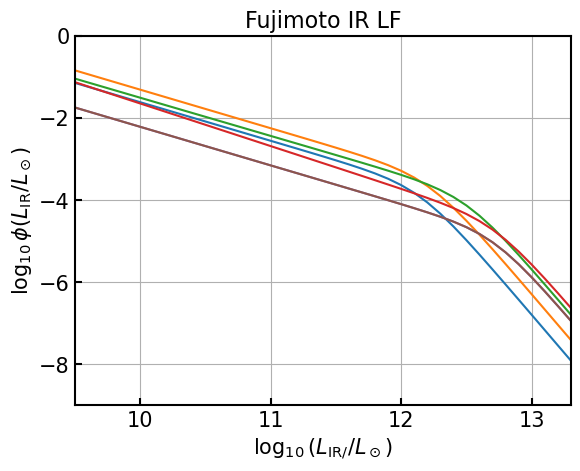

In [28]:
red_sample = np.array([0.8, 1.5, 2.5, 3.5, 5., 6.75])
for Z in red_sample:
    plt.plot(logLs, logLF[:,nearest(z,Z)])
plt.title("Fujimoto IR LF", fontsize=16)
plt.xlim(9.5, 13.3)
plt.ylim(-9,0)
plt.grid()
plt.xlabel(r"$\log_{10} \, (L_{\rm IR/}/L_\odot)$",fontsize=15)
plt.ylabel(r"$\log_{10} \, \phi (L_{\rm IR}/L_\odot)$",fontsize=15)
plt.tick_params(which='major', length=5, width=1.5, direction='in')

0.014612534848154548


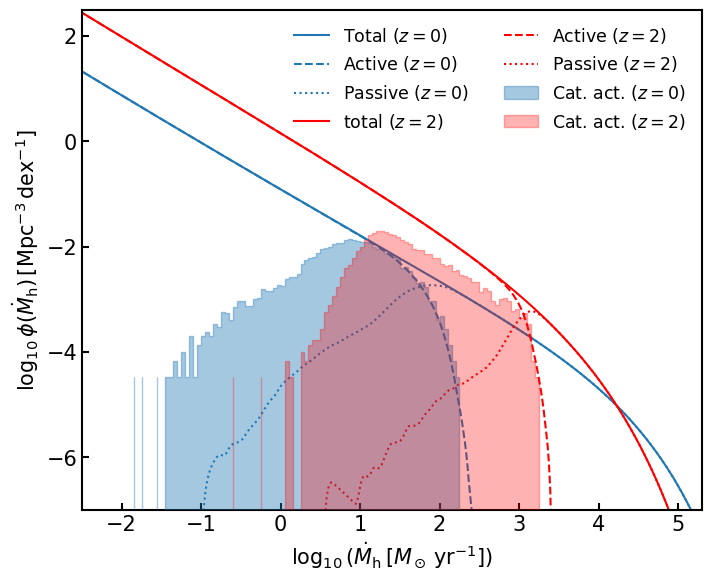

In [16]:
#plt.figure(figsize=(6,4.5))
plt.figure(figsize=(8,6.5))
#plt.vlines(cut_mhdotlog[0], -7,1, color='b', lw=0.5)
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot[0,:]),color='C0',label="Total ($z=0$)")
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot_active[0,:]),color='C0',linestyle='--',label="Active ($z=0$)")
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot_passive[0,:]),color='C0',linestyle=':',label="Passive ($z=0$)")

#plt.plot(mhdotlog-9.,np.log10(new_dNdVdlogmhdot_active[nearest(z,2),:]),color='black', ls=":",lw=3, label="Active updated")

Z2=2.
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot[nearest(z,Z2),:]),color='red',label="total ($z=2$)")
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot_active[nearest(z,Z2),:]),color='red',linestyle='--',label="Active ($z=2$)")
plt.plot(mhdotlog-9.,np.log10(dNdVdlogmhdot_passive[nearest(z,Z2),:]),color='red',linestyle=':',label="Passive ($z=2$)")

b = 0.05; har_range = np.arange(-6, 6, b)
phi_mhdotlog = np.histogram(dmhdtlog_arr[mhlog_arr[:,nearest(z,0)]<mhlog_crit(0),nearest(z,0)], bins=har_range)[0] / b / volume
#plt.plot(har_range[:-1]+b/2., np.log10(phi_mhdotlog))
plt.fill_between(har_range[:-1]+b, np.repeat(-10, phi_mhdotlog.size), np.log10(phi_mhdotlog), color="C0", step="pre", alpha=0.4, zorder=3, label="Cat. act. ($z=0$)")
print( trapz(phi_mhdotlog, har_range[:-1]) )

phi_mhdotlog = np.histogram(dmhdtlog_arr[mhlog_arr[:,nearest(z,2)]<mhlog_crit(2),nearest(z,2)], bins=har_range)[0] / b / volume
plt.fill_between(har_range[:-1]+b, np.repeat(-10, phi_mhdotlog.size), np.log10(phi_mhdotlog), color="red", step="pre", alpha=0.3, zorder=5, label="Cat. act. ($z=2$)")

plt.xlim(-2.5,5.3)
plt.ylim(-7,2.5)
plt.legend(frameon=False, ncol=2, fontsize=12.5)
plt.xlabel(r"$\log_{10} \, (\dot{M}_{\rm h} \, [M_\odot \, {\rm yr}^{-1}])$",fontsize=15)
plt.ylabel(r"$\log_{10} \, \phi (\dot{M}_{\rm h}) \, [{\rm Mpc}^{-3} \, {\rm dex}^{-1}]$",fontsize=15)
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#plt.savefig("../Figures_thesis/HAR_function_cat.pdf", bbox_inches="tight", dpi=300)


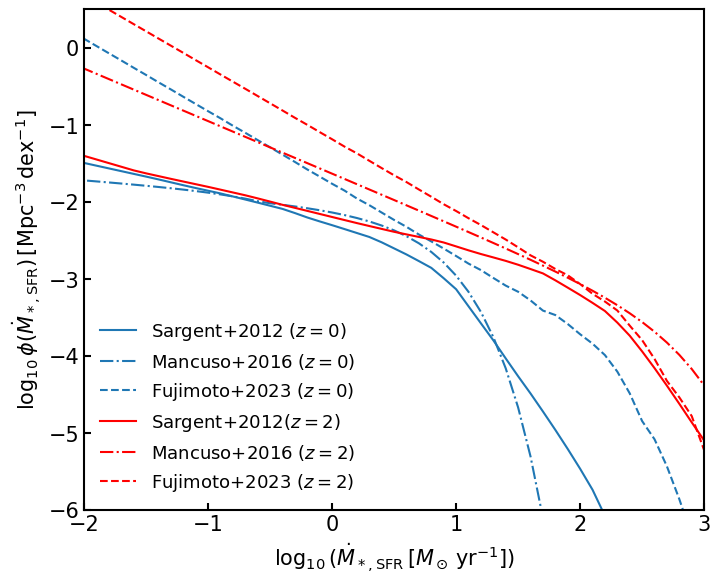

In [79]:
plt.figure(figsize=(8,6.5))

Z1=0.
plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,Z1)]), color="C0", label="Sargent+2012 ($z=0$)")
#plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,1)]), label="$z=1$")
#plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,2)]), color="red", label="Sargent+2012($z=2$)")
#plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,3)]), label="$z=3$")
#plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,4)]), label="$z=4$")

#for Z in [0,1,2.3]:
#    plt.plot(sfrlog, np.log10(phisfrLF_fujimoto[:,nearest(z,Z)]), "--", color="C"+str(Z))
#    plt.plot(sfrlog, np.log10(phisfr_lapi[:,nearest(z,Z)]), "-.", color="C"+str(Z))

phisfrLF_Fujimoto=np.loadtxt("Data/Fujimoto_SFRF/phiSFR_Fujimoto_2023.txt")
plt.plot(sfrlog, np.log10(phisfr_lapi[:,nearest(z,Z1)]), "-.", color="C0", label="Mancuso+2016 ($z=0$)")
plt.plot(sfrlog, np.log10(phisfrLF_Fujimoto[:,nearest(z,Z1)]), "--", color="C0", label="Fujimoto+2023 ($z=0$)")
plt.plot(sfrlog, np.log10(phisfrLF_Sargent[:,nearest(z,2)]), color="red", label="Sargent+2012($z=2$)")
plt.plot(sfrlog, np.log10(phisfr_lapi[:,nearest(z,2)]), "-.", color="red", label="Mancuso+2016 ($z=2$)")
plt.plot(sfrlog, np.log10(phisfrLF_Fujimoto[:,nearest(z,2)]), "--", color="red", label="Fujimoto+2023 ($z=2$)")

#bothwell=np.loadtxt("Bothwell_2011/SFRF.txt")
#plt.errorbar(bothwell[:,0], bothwell[:,1], yerr=[ bothwell[:,1]-bothwell[:,2], bothwell[:,3]-bothwell[:,1] ], ls="none", marker="o", capsize=0, color="purple", label="Bothwell+2011")

#plt.plot(10,10, "-", color="black", label="Sargent+2012")
#plt.plot(10,10, "--", color="black", label="Fujimoto+2023")
#plt.plot(10,10, "-.", color="black", label="Mancuso&Lapi")

plt.xlim(-2,3)
plt.ylim(-6,0.5)
plt.legend(frameon=False, fontsize=13, loc="lower left")
plt.xlabel(r"$\log_{10} \, (\dot{M}_{\rm *,SFR} \, [M_\odot \, {\rm yr}^{-1}])$",fontsize=15)
plt.ylabel(r"$\log_{10} \, \phi (\dot{M}_{\rm *,SFR}) \, [{\rm Mpc}^{-3} \, {\rm dex}^{-1}]$",fontsize=15)
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#plt.savefig("../Figures_thesis/SFR_function_comparison.pdf", bbox_inches="tight", dpi=300)

(-3.0, 3.0)

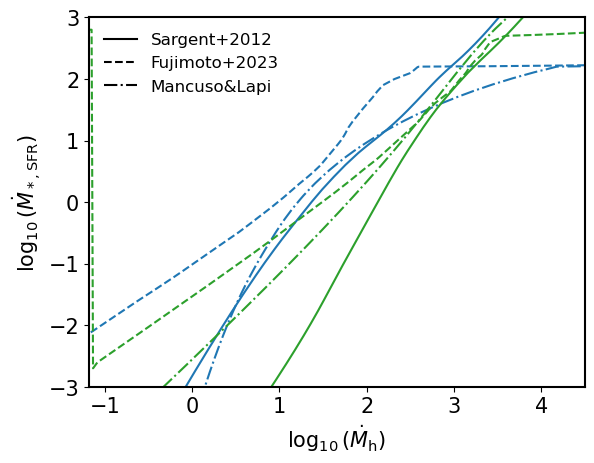

In [32]:
sfrlog_am_Sargent = abundance_matching(z,nz,mhdotlog,nmhdot, phisfrLF_Sargent, sfrlog,nsfr, dNdVdlogmhdot_active, sigma_sfr)
sfrlog_am_Fujimoto = abundance_matching(z,nz,mhdotlog,nmhdot, phisfrLF_Fujimoto, sfrlog,nsfr, dNdVdlogmhdot_active, sigma_sfr)
sfrlog_am_Lapi = abundance_matching(z,nz,mhdotlog,nmhdot, phisfr_lapi, sfrlog,nsfr, dNdVdlogmhdot_active, sigma_sfr)

for Z in [0,2]:
    plt.plot(mhdotlog-9, sfrlog_am_Sargent[1][:,nearest(z,Z)], "-", color="C"+str(Z))
    plt.plot(mhdotlog-9, sfrlog_am_Fujimoto[1][:,nearest(z,Z)], "--", color="C"+str(Z))
    plt.plot(mhdotlog-9, sfrlog_am_Lapi[1][:,nearest(z,Z)], "-.", color="C"+str(Z))
plt.plot(10,10, "-", color="black", label="Sargent+2012")
plt.plot(10,10, "--", color="black", label="Fujimoto+2023")
plt.plot(10,10, "-.", color="black", label="Mancuso&Lapi")
plt.legend(frameon=False,fontsize=12)
plt.xlabel(r"$\log_{10} \, (\dot{M}_{\rm h})$",fontsize=15)
plt.ylabel(r"$\log_{10} \, (\dot{M}_{\rm *,SFR})$",fontsize=15)
plt.xlim(-1.18,4.5)
plt.ylim(-3,3)

Text(0, 0.5, '$\\sigma \\, [{\\rm km/s}]$')

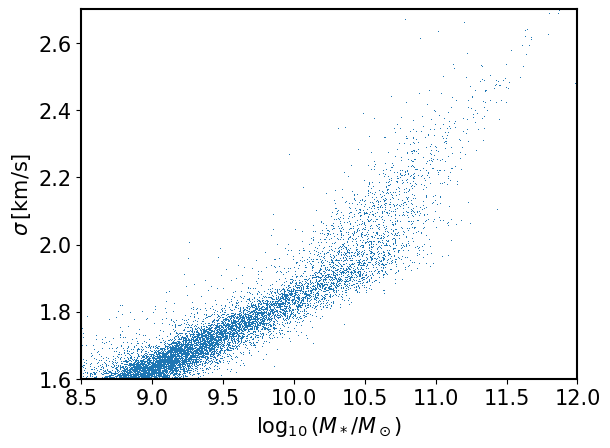

In [36]:
Z=0
plt.plot(logmstar_integrated[:,nearest(z,Z)], logsigma_arr[:,nearest(z,Z)], ",")
plt.xlim(8.5,12)
plt.ylim(1.6,2.7)
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=15)
plt.ylabel(r"$\sigma \, [{\rm km/s}]$", fontsize=15)

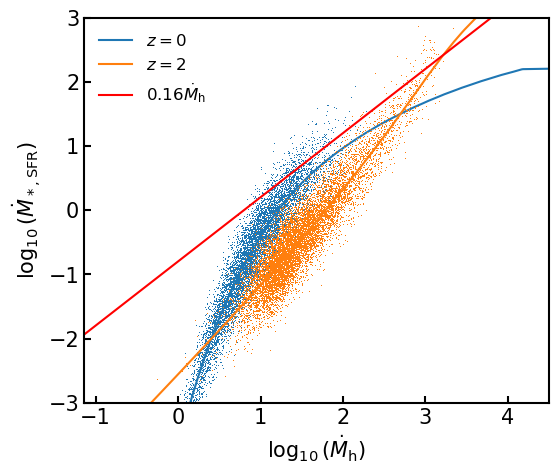

In [39]:
plt.figure(figsize=(6,5))

Z=0
plt.plot(dmhdtlog_arr[:,nearest(z,Z)], sfrlog_cat[:,nearest(z,Z)], ",")
plt.plot(mhdotlog-9,sfrlog_am[:,nearest(z,Z)], color="C0", label=r"$z=0$")
Z=2
plt.plot(dmhdtlog_arr[:,nearest(z,Z)], sfrlog_cat[:,nearest(z,Z)], ",")
plt.plot(mhdotlog-9,sfrlog_am[:,nearest(z,Z)], color="C1", label=r"$z=2$")
plt.plot(mhdotlog-9, mhdotlog-9+np.log10(0.16), color="red", label=r"$0.16 \dot{M}_{\rm h}$")

#plt.plot(mhdotlog-9,sfrlog_am[:,nearest(z,Z)]+2*sigma_sfr, "--", color="C0")
plt.xlim(-1.14,4.5)
plt.ylim(-3,3)
plt.legend(frameon=False, fontsize=12)
plt.xlabel(r"$\log_{10} \, (\dot{M}_{\rm h})$",fontsize=15)
plt.ylabel(r"$\log_{10} \, (\dot{M}_{\rm *,SFR})$",fontsize=15)
#plt.grid()
plt.tick_params(which='major', length=5, width=1.5, direction='in')
#plt.title("Sargent+2012", fontsize=15)

#plt.savefig("../Figures_thesis/SFR_HAR_quenchHaloOnly_Sargent+2012.jpg", bbox_inches="tight", dpi=300)

Text(0.5, 0, 'z')

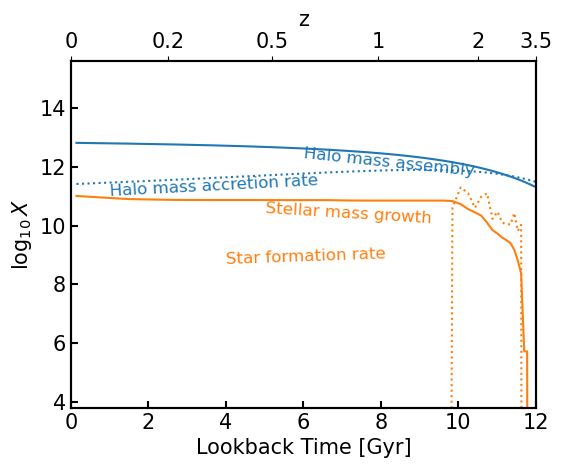

In [42]:
plt.figure(figsize=(6,4.5))
index=9700
plt.plot(lb_time, mhlog_arr[index,:], color="C0", label=r"$M_{\rm h}(z)$")
plt.plot(lb_time, dmhdtlog_arr[index,:]+9., ":", color="C0", label=r"$\dot{M}_{\rm h}(z)\,[M_\odot / {\rm Gyr}]$")
plt.plot(lb_time, logmstar_integrated[index,:], color="C1", label=r"$M_*(z)$")
plt.plot(lb_time, sfrlog_cat[index,:]+9., ":", color="C1", label=r"$\dot{M}_{\rm *,SFR}(z)\,[M_\odot / {\rm Gyr}]$")


plt.text(6, 11.7, "Halo mass assembly", color="C0", fontsize=12, rotation=-6.)
plt.text(1, 11., "Halo mass accretion rate", color="C0", fontsize=12, rotation=3)
plt.text(5, 10.1, "Stellar mass growth", color="C1", fontsize=12, rotation=-3.5)
plt.text(4, 8.7, "Star formation rate", color="C1", fontsize=12, rotation=2)


plt.tick_params(which='major', length=5, width=1.5, direction='in')#plt.legend(frameon=False, fontsize=13, loc="lower left", ncol=2)
plt.xlabel(r"$z$",fontsize=15)
plt.ylabel(r"$\log_{10} \, X$",fontsize=15)
plt.xlim(0.,12.)
plt.ylim(3.8, 15.6)
#plt.grid()

axes1 = plt.gca()
axes2 = axes1.twiny()

z_tick = np.array([0., 0.2, 0.5, 1., 2., cosmo.lookbackTime(12., inverse=True)])
t_tick = cosmo.lookbackTime(z_tick)
axes2.set_xticks(t_tick)
axes2.set_xticklabels(["0", "0.2", "0.5", "1", "2", "3.5"])

axes1.set_xlabel("Lookback Time [Gyr]")
axes2.set_xlabel("z", fontsize=15)

#plt.savefig("../Figures_paper/mass_acc_STARFORMING_example_BHQuenchOnly_Mancuso2016_Yang2018.pdf", bbox_inches="tight", dpi=300)


Text(0.5, 0, 'z')

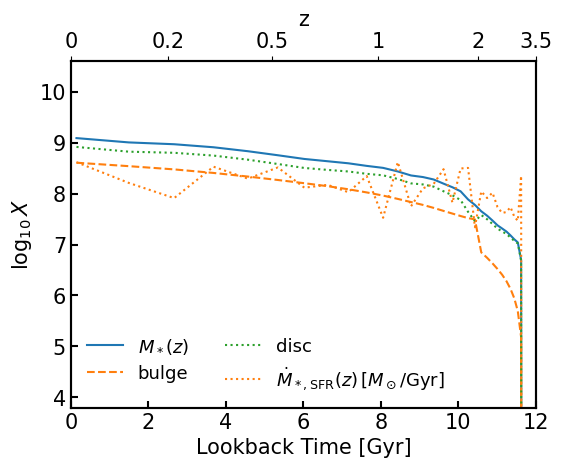

In [48]:
plt.figure(figsize=(6,4.5))
index=2800
plt.plot(lb_time, logmstar_integrated[index,:], label=r"$M_*(z)$")
plt.plot(lb_time, logmbulge[index,:], "--", label="bulge")
plt.plot(lb_time, logmdisc[index,:], ":", label="disc")
#plt.plot(lb_time, np.log10(10**logmdisc[index,:]+10**logmbulge[index,:]), ".", color="C0")
plt.plot(lb_time, sfrlog_cat[index,:]+9., ":", color="C1", label=r"$\dot{M}_{\rm *,SFR}(z)\,[M_\odot / {\rm Gyr}]$")

plt.legend(frameon=False, fontsize=13, loc="lower left", ncol=2)
plt.xlabel(r"$z$",fontsize=15)
plt.ylabel(r"$\log_{10} \, X$",fontsize=15)
plt.xlim(0.,12.)
plt.ylim(3.8, 10.6)
#plt.grid()
plt.tick_params(which='major', length=5, width=1.5, direction='in')#plt.legend(frameon=False, fontsize=13, loc="lower left", ncol=2)

axes1 = plt.gca()
axes2 = axes1.twiny()
z_tick = np.array([0., 0.2, 0.5, 1., 2., cosmo.lookbackTime(12., inverse=True)])
t_tick = cosmo.lookbackTime(z_tick)
axes2.set_xticks(t_tick)
axes2.set_xticklabels(["0", "0.2", "0.5", "1", "2", "3.5"])

axes1.set_xlabel("Lookback Time [Gyr]")
axes2.set_xlabel("z", fontsize=15)

#plt.savefig("../Figures_paper/mass_acc_STARFORMING_example_BHQuenchOnly_Mancuso2016_Yang2018.pdf", bbox_inches="tight", dpi=300)


(-6.5, 3.0)

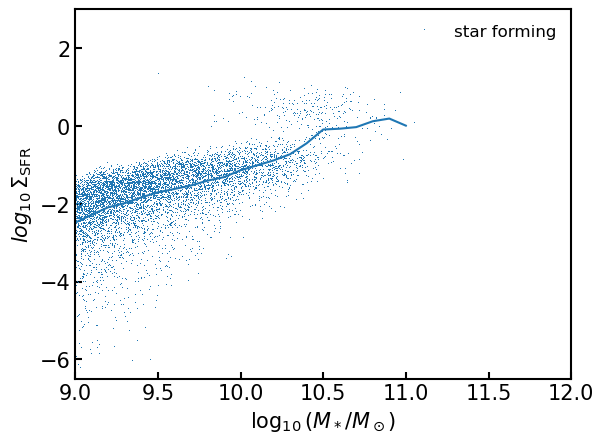

In [50]:
Z=0
index=nearest(z,Z)
sfrlog_threshold=-65.

plt.plot(logmstar_integrated[sfrlog_cat[:,index]>sfrlog_threshold,index],  logSigmaSFR[sfrlog_cat[:,index]>sfrlog_threshold,index], ",", color="C0", label="star forming")
mean_logRtotal = np.array([ np.mean(logSigmaSFR[np.logical_and.reduce((logSigmaSFR[:,index]>-66., logmstar_integrated[:,index]>m-Msbin/2., logmstar_integrated[:,index]<=m+Msbin/2., sfrlog_cat[:,index]>sfrlog_threshold)),index]) for m in Mslog ])
plt.plot(Mslog, mean_logRtotal, color="C0")

plt.tick_params(which='major', length=5, width=1.5, direction='in')#plt.legend(frameon=False, fontsize=13, loc="lower left", ncol=2)
plt.legend(frameon=False, fontsize=12)
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=15)
plt.ylabel(r"$log_{10}\, \Sigma_{\rm SFR}$", fontsize=15)
plt.xlim(9,12)
plt.ylim(-6.5,3)

No handles with labels found to put in legend.


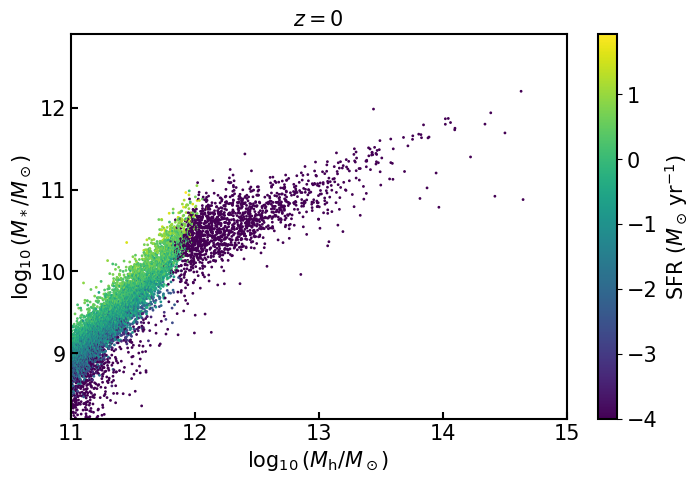

In [53]:
plt.figure(figsize=(8,5))
Z=0
index=nearest(z,Z)
plt.xlim(11.,15.)
plt.ylim(8.2,12.9)
plt.scatter(mhlog_arr[:,index],logmstar_integrated[:,index], s=1,c=sfrlog_cat[:,index],vmin=-4)
mbin=0.1; Mhlog=np.arange(10,15.5,mbin)
mean_smhm = np.array([ np.mean(logmstar_integrated[np.logical_and.reduce((logmstar_integrated[:,index]>0., mhlog_arr[:,index]>m-mbin/2., mhlog_arr[:,index]<=m+mbin/2.)),index]) for m in Mhlog ])

plt.colorbar().set_label(label=r"SFR ($M_\odot \, {\rm yr}^{-1}$)",size=15)
plt.title("$z=$%.0f"%z[index], fontsize=15)
plt.legend(frameon=False, fontsize=12)
plt.xlabel(r"$\log_{10} \, (M_{\rm h} / M_\odot)$",fontsize=15)
plt.ylabel(r"$\log_{10} \, (M_* / M_\odot)$",fontsize=15)
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#plt.savefig("../Figures_paper/SMHM_quenchHaloOnly_Mancuso_z=%.2f.jpg"%Z, bbox_inches="tight", dpi=300)

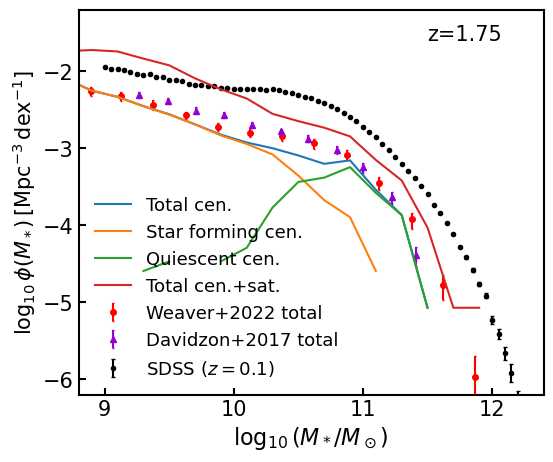

In [54]:
Z = 1.75
b = 0.2; Mstar_range = np.arange(8, 12.5, b)
phi_mslog = np.histogram(logmstar_integrated[:,nearest(z,Z)], bins=Mstar_range)[0] / b / volume
phi_mslog_quench = np.histogram(logmstar_integrated[sfrlog_cat[:,nearest(z,Z)]<-60,nearest(z,Z)], bins=Mstar_range)[0] / b / volume
phi_mslog_active = np.histogram(logmstar_integrated[sfrlog_cat[:,nearest(z,Z)]>-60,nearest(z,Z)], bins=Mstar_range)[0] / b / volume
plt.figure(figsize=(6,5))
plt.plot(Mstar_range[:-1]+b/2., np.log10(phi_mslog), label="Total cen.")
plt.plot(Mstar_range[:-1]+b/2., np.log10(phi_mslog_active), label="Star forming cen.")
plt.plot(Mstar_range[:-1]+b/2., np.log10(phi_mslog_quench), label="Quiescent cen.")

#plt.plot(mslog, np.log10(smf_ac[nearest(z,Z),:]), lw=3, label="input active")

mhlog_smhm=np.arange(10,15.5,b)
mslog_smhm = np.array([ np.mean(logmstar_integrated[np.logical_and.reduce((logmstar_integrated[:,nearest(z,Z)]>8., mhlog_arr[:,nearest(z,Z)]>m-b/2., mhlog_arr[:,nearest(z,Z)]<=m+b/2.)),nearest(z,Z)]) for m in mhlog_smhm ])
scatter_smhm = np.array([ np.std(logmstar_integrated[np.logical_and.reduce((logmstar_integrated[:,nearest(z,Z)]>8., mhlog_arr[:,nearest(z,Z)]>m-b/2., mhlog_arr[:,nearest(z,Z)]<=m+b/2.)),nearest(z,Z)]) for m in mhlog_smhm ])
#smhm = interp1d(mhlog_smhm[np.isfinite(mslog_smhm)], mslog_smhm[np.isfinite(mslog_smhm)], fill_value="extrapolate")
popt,pcov=curve_fit(SMHM_double_pl, mhlog_smhm[np.isfinite(mslog_smhm)], mslog_smhm[np.isfinite(mslog_smhm)], p0 = [0.032,12.,2.,0.608])
smhm = interp1d(Mhlog, SMHM_double_pl(Mhlog,*popt), fill_value="extrapolate")
scatter = np.mean(scatter_smhm[np.isfinite(scatter_smhm)])
#scatter = interp1d(mhlog_smhm[np.isfinite(mslog_smhm)], scatter_smhm[np.isfinite(scatter_smhm)], fill_value="extrapolate")((halo_masses))
#scatter[scatter<0]=0

smhm, scatter = SMHM_scatter_from_logms_cat(logmstar_integrated, mhlog_arr, nearest(z,Z), mhlog_smhm, Mstar_range, b, volume, hmf, mhlog, mhlog_min)

delta_hmf = hmf[:,nearest(z,Z)] - hmf_cat[:,nearest(z,Z)]
halo_masses = compute_objs_from_mass_function(mhlog, delta_hmf, volume, mask=np.logical_and(delta_hmf>0.,mhlog>11))
mslog_mock_cat = smhm(halo_masses) + np.random.normal(0.,scatter, halo_masses.size)
delta_smf = np.histogram(mslog_mock_cat, bins=Mstar_range)[0] / b / volume

correction = compute_subHMF(z[nearest(z,Z)], mhlog, hmf[:,nearest(z,Z)])
halo_masses = compute_objs_from_mass_function(mhlog, correction, volume, mask=mhlog>11)
sats_mslog_mock_cat = smhm(halo_masses) + np.random.normal(0.,scatter, halo_masses.size)
phi_sats = np.histogram(sats_mslog_mock_cat, bins=Mstar_range)[0] / b / volume

phi_mslog_tot=phi_mslog+delta_smf+phi_sats
plt.plot(Mstar_range[:-1]+b/2., np.log10(phi_mslog_tot), label="Total cen.+sat.")

smf_obs = np.loadtxt("Data/Weaver_smf_data/SMF_tot_%.2f.txt"%Z)
plt.errorbar(smf_obs[:,0], smf_obs[:,1], yerr=[ smf_obs[:,1]-smf_obs[:,2], smf_obs[:,3]-smf_obs[:,1] ], ls="none", marker="o", markersize=4, capsize=1, color="red", label="Weaver+2022 total", zorder=-9)

smf_obs = np.loadtxt("Data/Weaver_smf_data/SMF_ac_%.2f.txt"%Z)
#plt.errorbar(smf_obs[:,0], smf_obs[:,1], yerr=[ smf_obs[:,1]-smf_obs[:,2], smf_obs[:,3]-smf_obs[:,1] ], ls="none", marker="o", markersize=4, capsize=1, color="blue", label="Weaver+2022 active")

philog_ac_dav = smf_active(z,nz,ms,nms, work="Davidzon+2017")
philog_pas_dav = smf_passive(z,nz,ms,nms, work="Davidzon+2017")
philog_dav = np.log10(10**philog_ac_dav+10**philog_pas_dav)
#plt.plot(mslog, philog_dav[nearest(z,Z),:], label="Davidzon total")
smf_obs = np.loadtxt("../../Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Davidzon+2017/SMF_Davidzon_tot_%.2f.dat"%Z)
plt.errorbar(smf_obs[:,0], smf_obs[:,1], yerr=[ smf_obs[:,1]-smf_obs[:,2], smf_obs[:,3]-smf_obs[:,1] ], ls="none", marker="^", markersize=4, capsize=1, color="darkviolet", label="Davidzon+2017 total", zorder=-8)

sdss = np.loadtxt("../../Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/SDSS_data/SMF_total.txt")
sdss_sigma = sdss[:,2] / (sdss[:,1] * np.log(10.))
plt.errorbar(sdss[:,0], np.log10(sdss[:,1]), yerr=sdss_sigma, color="black", fmt='.', capsize=1.5, label=r"SDSS ($z=0.1$)", zorder=-10)

#plt.title("Fujimoto+2023", fontsize=15)
plt.text(11.5, -1.6, "z=%.2f"%Z, fontsize=15)
plt.legend(frameon=False, fontsize=13, loc="lower left")
plt.xlim(8.8, 12.4)
plt.ylim(-6.2, -1.2)
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=16)
plt.ylabel(r"$\log_{10} \, \phi (M_*) \, [{\rm Mpc}^{-3} \, {\rm dex}^{-1}]$", fontsize=15)
#plt.grid()
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#np.savetxt("Output_data/SMF_quenchHaloOnly_Fujimoto_z=%.2f.txt"%Z, np.transpose([Mstar_range[:-1]+b/2., np.log10(phi_mslog), np.log10(phi_mslog_quench), np.log10(phi_mslog_active), np.log10(phi_mslog_tot), np.log10(phi_mslog_tot_NoMerg)]))
#plt.savefig("../Figures_paper/SMF_BHquenchOnly_Mancuso2016_Yang2018_z=%.2f.pdf"%Z, bbox_inches="tight", dpi=300)


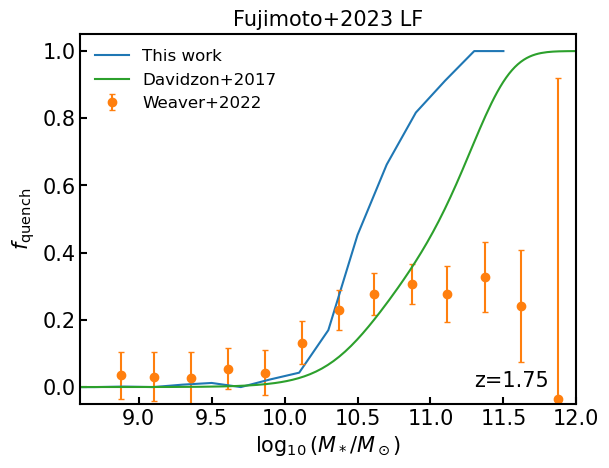

In [55]:
#Z=1.75
f_quenched_sats=0.
f_sats=interp1d(Mstar_range[:-1]+b/2., 1-phi_mslog/phi_mslog_tot,fill_value="extrapolate")(Mstar_range[:-1]+b/2.)
plt.plot(Mstar_range[:-1]+b/2., phi_mslog_quench/phi_mslog, label="This work")#+f_quenched_sats*f_sats)

smf_obs_tot = np.loadtxt("Data/Weaver_smf_data/SMF_tot_%.2f.txt"%Z)
smf_obs_ac = np.loadtxt("Data/Weaver_smf_data/SMF_ac_%.2f.txt"%Z)
smf_tot=interp1d(smf_obs_tot[:,0],smf_obs_tot[:,1],fill_value="extrapolate")
smf_ac=interp1d(smf_obs_ac[:,0],smf_obs_ac[:,1],fill_value="extrapolate")
#plt.plot(Mstar_range, 1-10**smf_ac(Mstar_range)/10**smf_tot(Mstar_range), label="Weaver")
f_obs = np.loadtxt("Data/Weaver_smf_data/frac_quenched_%.2f.txt"%Z)
plt.errorbar(f_obs[:,0], f_obs[:,1], yerr=f_obs[:,2]/2., ls="none", marker="o", capsize=2, label="Weaver+2022")

#f_dav = np.loadtxt("../../Discrete-Statistical-Semi-Empirical-Model/DREAM/Data/Davidzon+2017/f_quenched/f_quench_Dav2017.txt")
#plt.plot(f_dav[:,0], f_dav[:,1], "-.", label="Davidzon")
plt.plot(mslog, 10**philog_pas_dav[nearest(z,Z),:]/10**philog_dav[nearest(z,Z),:], label="Davidzon+2017")

plt.text(11.3, 0., "z=%.2f"%Z, fontsize=15)
plt.title("Fujimoto+2023 LF", fontsize=15)
plt.legend(frameon=False,fontsize=12)
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=15)
plt.ylabel(r"$f_{\rm quench}$", fontsize=15)
plt.xlim(8.6,12)
plt.ylim(-0.05,1.05)
#plt.grid()
plt.tick_params(which='major', length=5, width=1.5, direction='in')

#np.savetxt("Output_data/f_quench_quenchHaloOnly_Fujimoto_z=%.2f.txt"%Z, np.transpose([Mstar_range[:-1]+b/2., phi_mslog_quench/phi_mslog]))
#plt.savefig("../Figures_paper/f_quench_BHquenchOnly_Mancuso2016_Yang2018_z=%.2f.pdf"%Z, bbox_inches="tight", dpi=300)


No handles with labels found to put in legend.


Text(0, 0.5, '$log_{10}\\, \\dot{M}_{\\rm SFR}$')

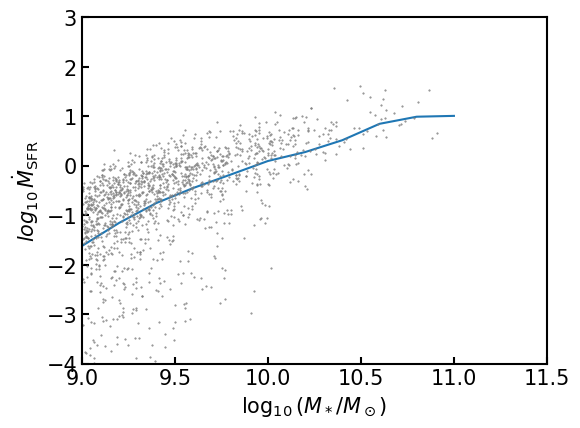

In [59]:
Z=0.
index=nearest(z,Z)
plt.figure(figsize=(6,4.5))
main_sequence = np.array([ np.mean(sfrlog_cat[np.logical_and.reduce((sfrlog_cat[:,index]>-65., logmstar_integrated[:,index]>m-b/2., logmstar_integrated[:,index]<=m+b/2.)),index]) for m in Mstar_range ])

plt.plot(Mstar_range, main_sequence)

mask=np.array([],dtype=bool)
for ihalo in range(nhalo):
    if tree["mratio"][ihalo][np.logical_and(tree["mratio"][ihalo]>=mratio_threshold,tree["z_merge"][ihalo]<3)].size>0:
        mask=np.append(mask,True)
    else:
        mask=np.append(mask,False)

not_mask=np.array([not mask[i] for i in range(mask.size)])
plt.plot(logmstar_integrated[mask,index], sfrlog_cat[mask,index], ".", color="grey", ms=1)
#plt.plot(logmstar_integrated[not_mask,index], sfrlog_cat[not_mask,index], ".", color="orange")

plt.xlim(9,11.5)
plt.ylim(-4,3)
plt.legend(frameon=False, fontsize=12)
plt.tick_params(which='major', length=5, width=1.5, direction='in')
plt.xlabel(r"$\log_{10} \, (M_* / M_\odot)$", fontsize=15)
plt.ylabel(r"$log_{10}\, \dot{M}_{\rm SFR}$", fontsize=15)